## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline
#%matplotlib notebook # required for training plots

env: CUDA_VISIBLE_DEVICES=0


In [24]:
import matplotlib.pyplot as plt
import matplotlib
import os                                                                       
import numpy as np                                                              
import tensorflow as tf                                                         
import data.data_picker as dp                                                   
import utils.plot_functions as pf                                               
import utils.image_processing as ip                                             
import utils.notebook as nb

import matplotlib.gridspec as gsp

## Model parameters

In [3]:
params = {
  ## Model params
  "out_dir": os.path.expanduser("~")+"/Work/Projects/ICAstrongPCA/outputs/",
  "chk_dir": os.path.expanduser("~")+"/Work/Projects/ICAstrongPCA/checkpoints/",
  "data_dir": os.path.expanduser("~")+"/Work/Datasets/",
  "load_chk": True,
  "load_cov": True,
  "update_interval": 500,
  "device": "/gpu:0",
  "prior": "laplacian",
  "learning_rate": 0.01,
  "num_neurons": int(16**2),
  "eta": 0.001/0.03, #dt/tau
  "eps": 1e-12,
  "max_cp_to_keep": 2,
  ## Data params
  "data_type": "vanhateren",
  "rand_state": np.random.RandomState(12345),
  "num_images": 100,
  "num_batches": int(1e5), #Total dataset size is num_batches*batch_size
  "batch_size": 100,
  "patch_edge_size": 16,
  "overlapping_patches": True,
  "patch_variance_threshold": 1e-6,
  "conv": False,
  "whiten_images": False,
  "contrast_normalize": False,
  ## Fourier analysis params
  "ft_padding": 20,
  ## Pooling params
  "cov_num_images":int(1e7),
  "num_pooling_dims": 24, #K
  ## Visualization params
  "num_pooling_filters":50,
  "num_connected_weights":250}

## Calculated params
params["epoch_size"] = params["batch_size"] * params["num_batches"]
params["num_training_steps"] = 20000 # params["num_batches"] # Could be set to less, model trains in 20k
params["num_pixels"] = int(params["patch_edge_size"]**2)
params["dataset_shape"] = [int(val)
    for val in [params["epoch_size"], params["num_pixels"]]],
params["phi_shape"] = [params["num_neurons"], params["num_pixels"]]

## Functions for analysis

### Pooling filters function

In [4]:
def compute_pooling_filters(activity_covariance, num_pooling_dims):
  evals, evecs = np.linalg.eig(activity_covariance)
  sort_indices = np.argsort(evals)[::-1]
  top_vecs = evecs[:, sort_indices[:num_pooling_dims]]
  pooling_filters = np.dot(top_vecs, top_vecs.T)
  return pooling_filters

## Load dataset

In [5]:
if not params["load_cov"] or not params["load_chk"]: 
  data = dp.get_data(params["data_type"], params)                                 
  params["input_shape"] = [                                                       
      data["train"].num_rows*data["train"].num_cols*data["train"].num_channels]     

## Define graph

In [6]:
graph = tf.Graph()
with tf.device(params["device"]):
  with graph.as_default():
    with tf.name_scope("placeholders") as scope:
      x = tf.placeholder(tf.float32, shape=[None, params["num_pixels"]],
        name="input_data")

    with tf.name_scope("step_counter") as scope:
      global_step = tf.Variable(0, trainable=False, name="global_step")

    with tf.variable_scope("weights") as scope:
      ## Q matrix from QR decomp is guaranteed to be orthonormal and
      ## non-singular, which prevents a gradient explosion from inverting
      ## the weight matrix.
      Q, R = np.linalg.qr(np.random.standard_normal(params["phi_shape"]))
      phi = tf.get_variable(name="phi", dtype=tf.float32,
        initializer=Q.astype(np.float32), trainable=True)

    with tf.name_scope("inference") as scope:
      u = tf.matmul(x, tf.matrix_inverse(phi, name="phi_inverse"),
        name="coefficients")
      if params["prior"] == "laplacian":
        a = tf.sign(u)
      else: #It must be laplacian or cauchy
        a = (2*u) / (1 + tf.pow(u, 2.0))
      u_covariance = tf.divide(tf.matmul(tf.transpose(tf.nn.relu(u)), tf.nn.relu(u)),
        tf.to_float(tf.shape(x)[0]), name="u_cov_matrix")

    with tf.name_scope("optimizers") as scope:
      learning_rates = tf.train.exponential_decay(
        learning_rate=params["learning_rate"],
        global_step=global_step,
        decay_steps=int(np.floor(params["num_batches"]*0.8)),
        decay_rate=0.7,
        staircase=True,
        name="phi_annealing_schedule")
      optimizer = tf.train.GradientDescentOptimizer(learning_rates, name="phi_optimizer")
      a_u_avg = tf.divide(tf.matmul(tf.transpose(u), a),                   
        tf.to_float(tf.shape(x)[0]), name="avg_samples")                        
      gradient = -tf.subtract(tf.matmul(a_u_avg, phi), phi, name="phi_gradient")                                                
      update_weights = optimizer.apply_gradients([(gradient, phi)], global_step=global_step)

    full_saver = tf.train.Saver(var_list=[phi], max_to_keep=2)

    with tf.name_scope("summaries") as scope:
      #tf.summary.image("input", tf.reshape(x, [params["batch_size"],
      #  params["patch_edge_size"], params["patch_edge_size"], 1]))
      tf.summary.histogram("u", u)
      tf.summary.histogram("a", a)
      tf.summary.histogram("phi", phi)

    merged_summaries = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(params["out_dir"], graph)

    with tf.name_scope("initialization") as scope:
      init_op = tf.group(tf.global_variables_initializer(),
        tf.local_variables_initializer())

## Train LCA model (if needed)

In [7]:
if not params["load_chk"]:
  if not os.path.exists(params["out_dir"]):
    os.makedirs(params["out_dir"])
  if not os.path.exists(params["chk_dir"]):
    os.makedirs(params["chk_dir"])

  with tf.Session(graph=graph) as sess:
    sess.run(init_op,
    feed_dict={x:np.zeros([params["batch_size"]]+params["input_shape"],
      dtype=np.float32)})
    sess.graph.finalize() # Graph is read-only after this statement
    
    #fig, sub_ax = plt.subplots(1, 1, figsize=(10, 10))  
    #init_data = sess.run(phi)
    #init_data = ip.normalize_data_with_max(init_data)
    #plot_data = pf.pad_data(init_data.reshape((params["num_neurons"],
    #  params["patch_edge_size"], params["patch_edge_size"])))
    #im_ax = sub_ax.imshow(plot_data, cmap="Greys_r", interpolation="nearest")
    #sub_ax.tick_params(axis="both", bottom="off", top="off", left="off", right="off")
    #sub_ax.get_xaxis().set_visible(False)
    #sub_ax.get_yaxis().set_visible(False)
    #plt.show()
    for b_step in range(params["num_training_steps"]):
      input_data = data["train"].next_batch(params["batch_size"])[0]
      feed_dict = {x:input_data}
      sess.run(update_weights, feed_dict)

      current_step = sess.run(global_step)
      if (current_step % params["update_interval"] == 0):
        summary = sess.run(merged_summaries, feed_dict)
        train_writer.add_summary(summary, current_step)
        full_saver.save(sess, save_path=params["chk_dir"]+"ica_chk", global_step=global_step)
        #weights = sess.run(phi, feed_dict)
        #weights = ip.normalize_data_with_max(weights)
        #plot_data = pf.pad_data(weights.reshape((params["num_neurons"],
        #  params["patch_edge_size"], params["patch_edge_size"])))
        #im_ax.set_data(plot_data)
        #sub_ax.set_title("Basis Functions at Time Step "+str(current_step), fontsize=24)  
        #fig.canvas.draw()
    full_saver.save(sess, save_path=params["chk_dir"]+"ica_chk",
      global_step=global_step)

## Compute activity covariance & pooling filters

### Compute activity covariance matrix

In [8]:
if params["load_cov"]:
  u_cov = np.load(params["out_dir"]+"u_cov.npz")["data"]
  weights = np.load(params["out_dir"]+"weights.npz")["data"]
else:
  with tf.Session(graph=graph) as sess:
    sess.run(init_op,
      feed_dict={x:np.zeros([params["batch_size"]]+params["input_shape"],
      dtype=np.float32)})
    full_saver.restore(sess, tf.train.latest_checkpoint(params["chk_dir"]))
    weights = sess.run(phi).T
    u_cov = None
    num_cov_in_avg = 0
    tot_images = 0
    for tot_images in nb.log_progress(range(0, params["cov_num_images"], params["batch_size"]), every=1):
      input_data = data["train"].next_batch(params["batch_size"])[0]
      feed_dict = {x:input_data}
      if u_cov is None:
        u_cov = sess.run(u_covariance, feed_dict)
      else:
        u_cov += sess.run(u_covariance, feed_dict)
      num_cov_in_avg += 1
    u_cov /= num_cov_in_avg
  np.savez(params["out_dir"]+"u_cov.npz", data=u_cov)
  np.savez(params["out_dir"]+"weights.npz", data=weights)
#import scipy.io as sio
#sio.savemat(params["out_dir"]+"u_cov.mat", {"u_cov":u_cov})
#sio.savemat(params["out_dir"]+"phi_weights.mat", {"weights":weights})
u_evals, u_evecs = np.linalg.eig(u_cov)
u_sort_indices = np.argsort(u_evals)[::-1]

### Compute pooling filters

In [9]:
pooling_filters = compute_pooling_filters(u_cov, params["num_pooling_dims"])

In [10]:
bf_stats = ip.get_dictionary_stats(weights, padding=20, num_gauss_fits=20, gauss_thresh=0.3)

## Construct analysis plots

### Activity covariance matrix summaries

#### Activity covariance matrix

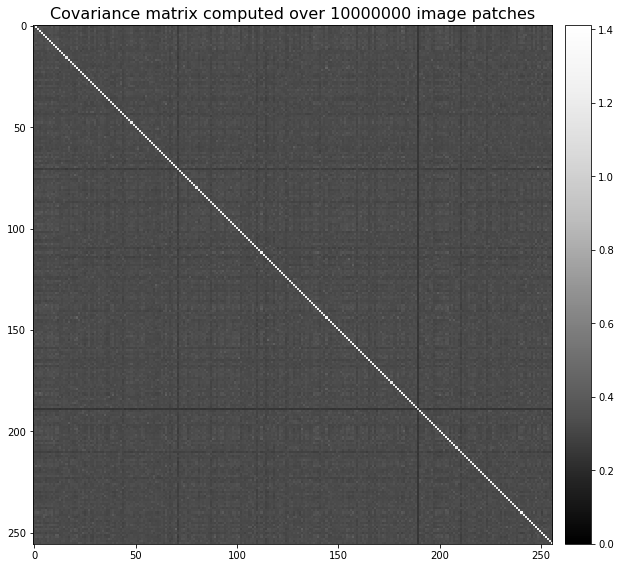

In [11]:
pf.plot_cov_matrix(u_cov, str(params["cov_num_images"]))

#### Eigenvalues of the activity covariance matrix

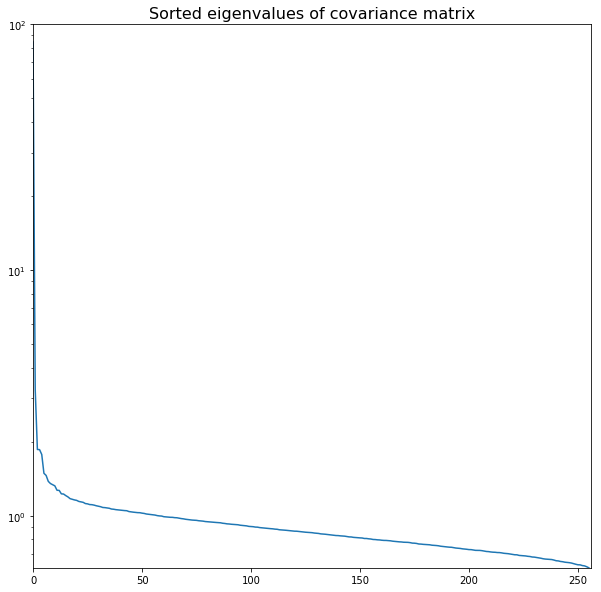

In [12]:
pf.plot_eigenvalues(u_evals[u_sort_indices], ylim=[0, 100])

#### Top connected basis functions

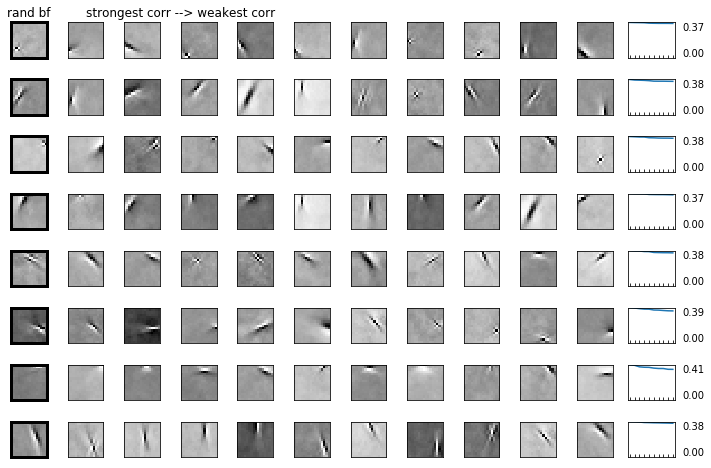

In [13]:
num_random_bases = 8
num_top_cov_bases = 10
bf_indices = np.random.choice(np.arange(u_cov.shape[0]), num_random_bases)
pf.plot_top_bases(u_cov, weights, bf_indices, num_top_cov_bases)

### Basis function analysis

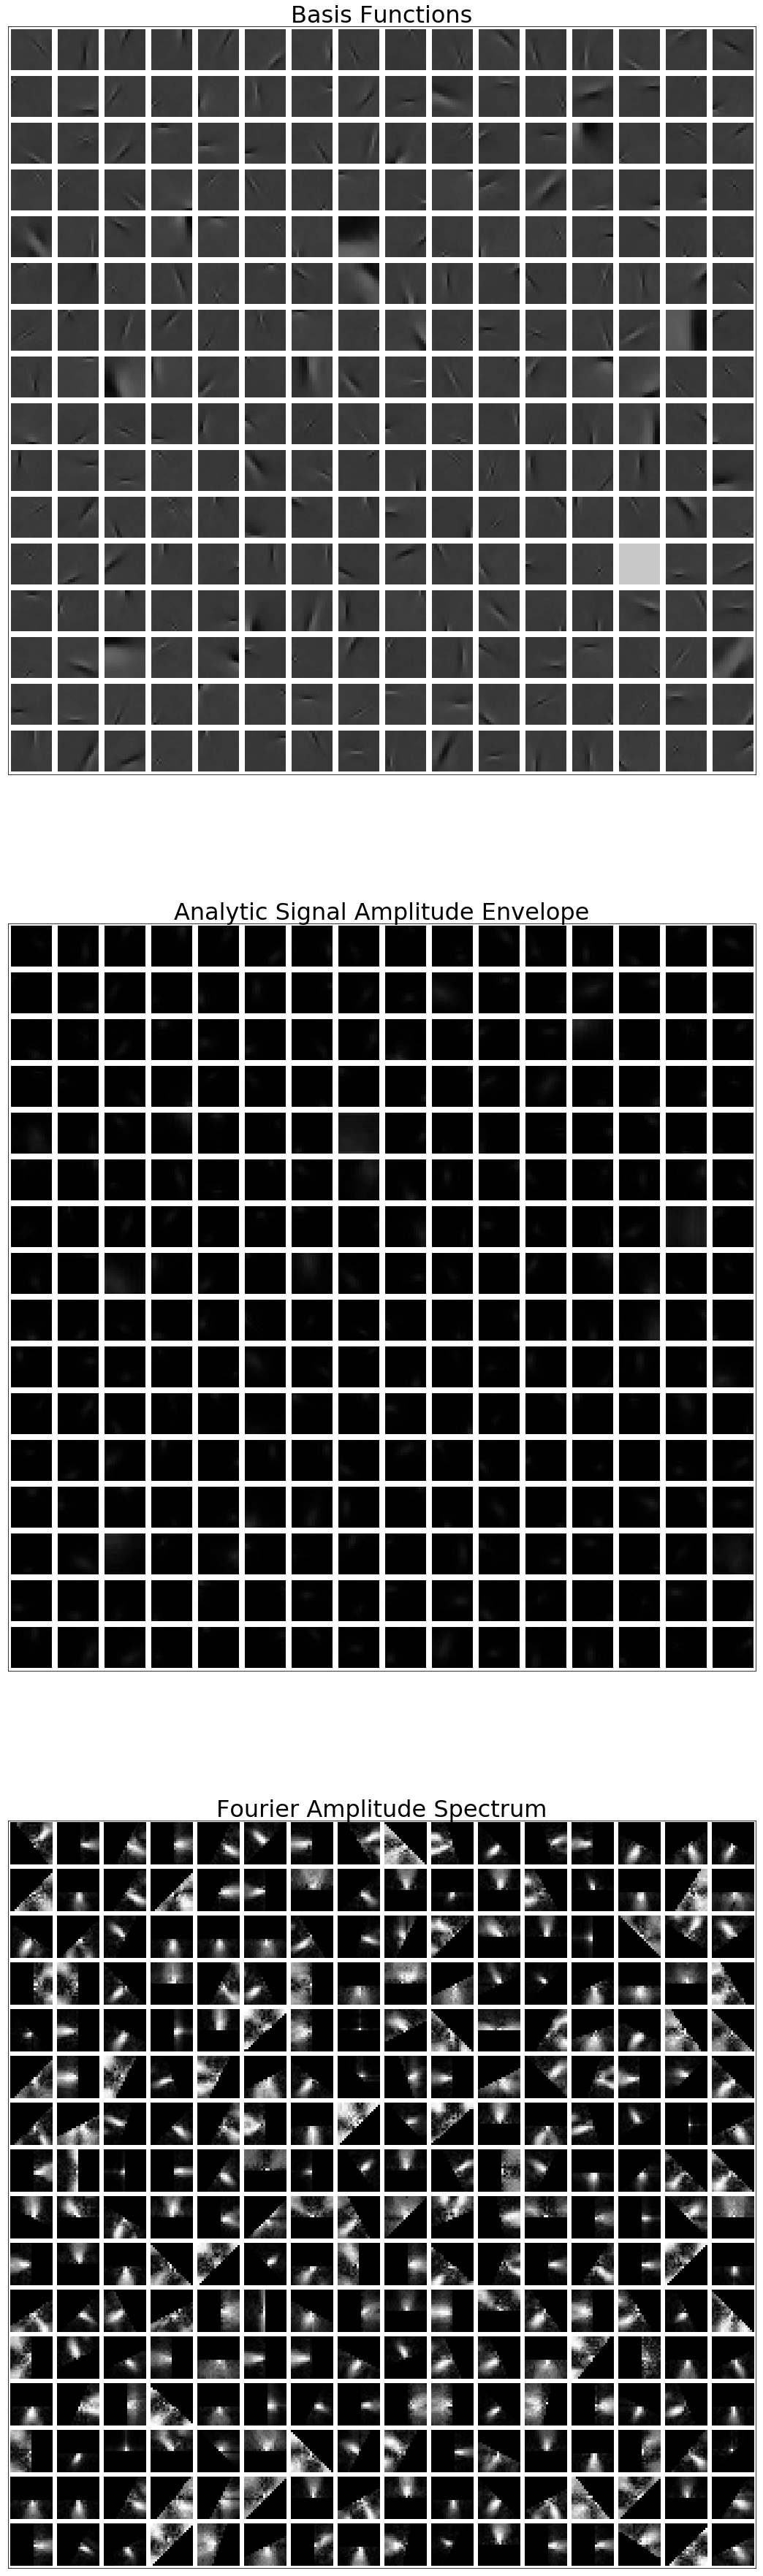

In [14]:
pf.plot_hilbert_analysis(weights, params["ft_padding"])

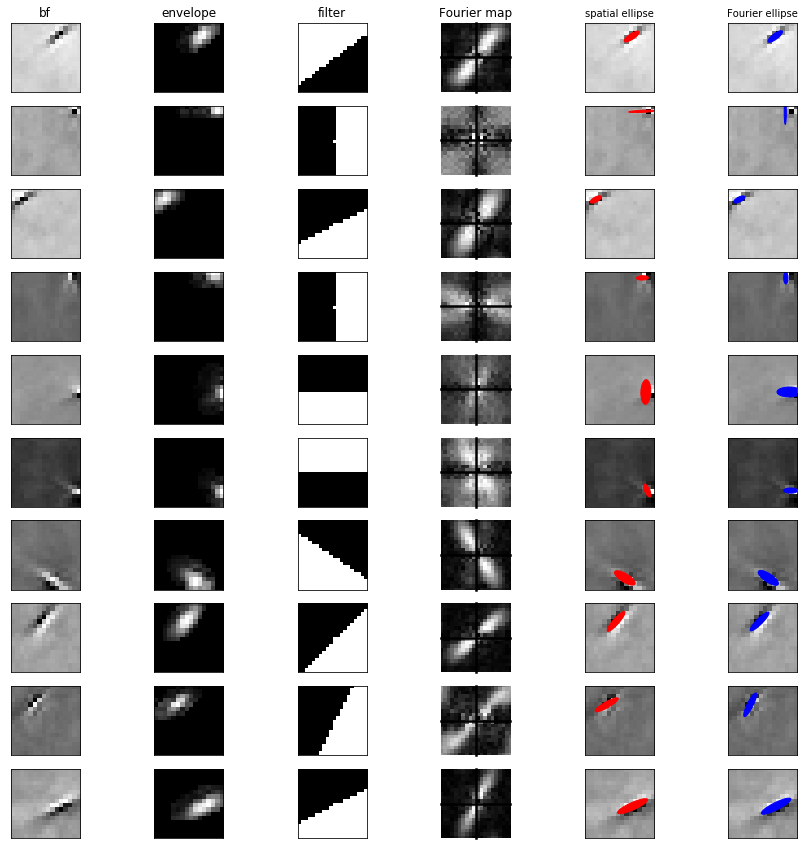

In [15]:
pf.plot_bf_stats(bf_stats, num_bf=10)

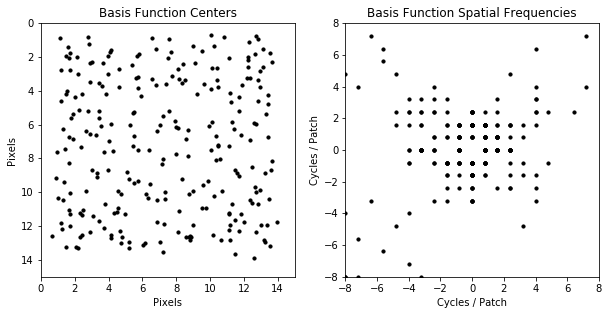

In [16]:
pf.plot_loc_freq_summary(bf_stats)

### Pooling and eigen summary plots

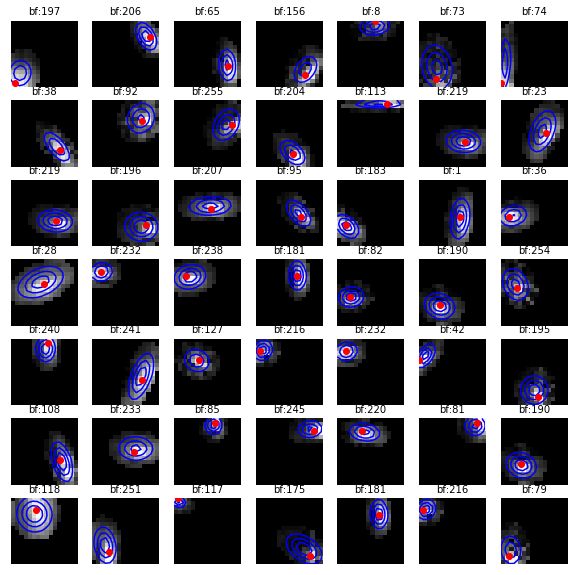

In [17]:
pf.plot_gaussian_contours(bf_stats, num_plots=49)

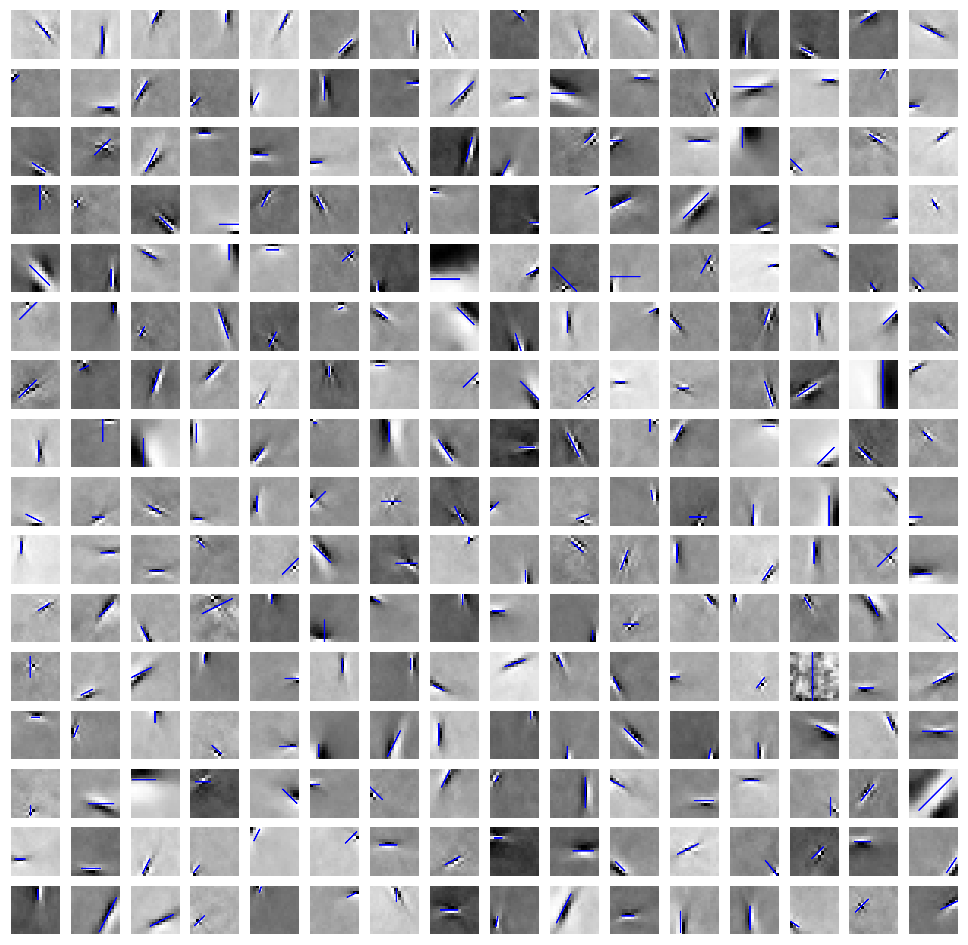

In [18]:
pf.plot_ellipse_summaries(bf_stats, num_bf=params["num_neurons"], lines=True)

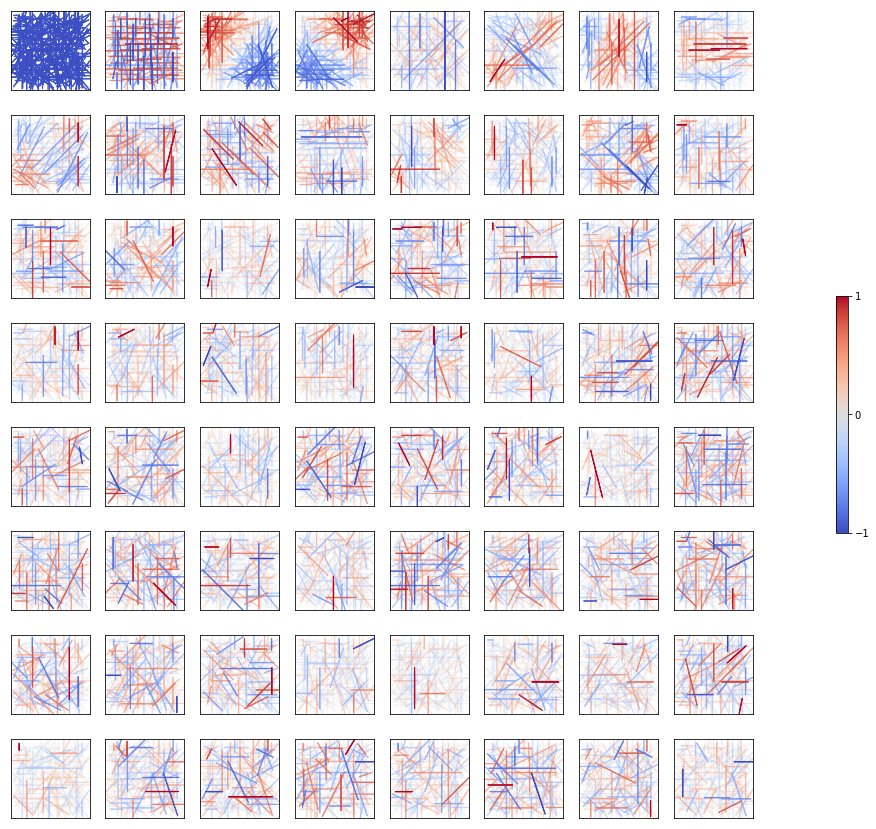

In [19]:
params["num_pooling_filters"] = 64
params["num_connected_weights"] = params["num_neurons"]#250#75
pf.plot_pooling_summaries(bf_stats, u_evecs[:, u_sort_indices[:params["num_pooling_filters"]]],
  params["num_pooling_filters"], params["num_connected_weights"], lines=True)

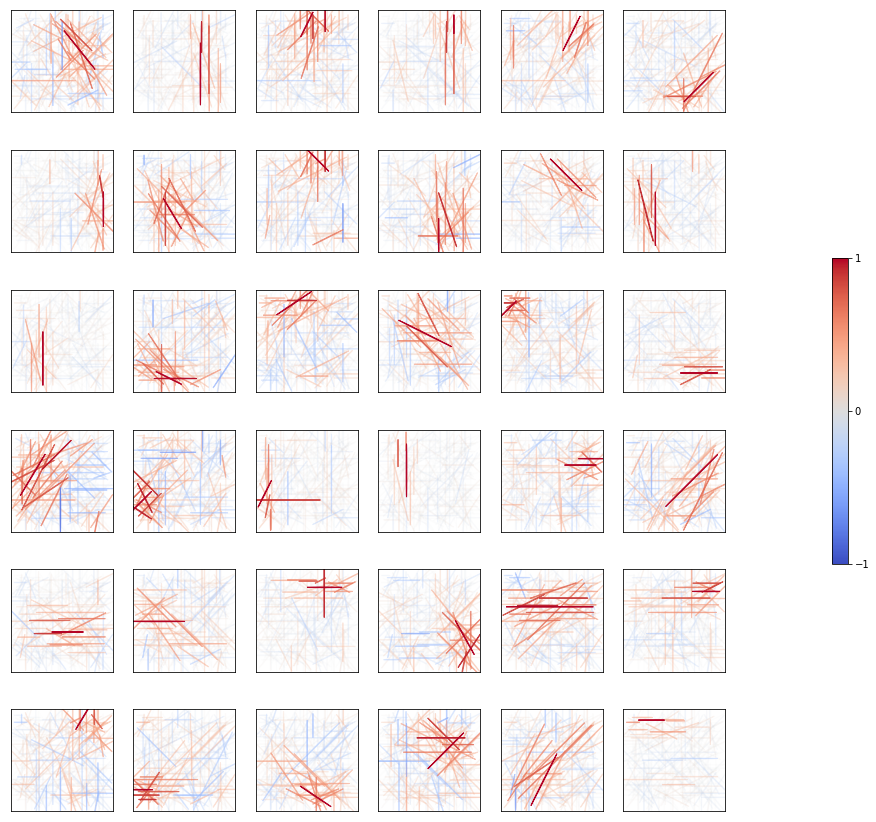

In [20]:
params["num_pooling_filters"] = 36
params["num_connected_weights"] = params["num_neurons"]#250#75
pf.plot_pooling_summaries(bf_stats, pooling_filters, params["num_pooling_filters"],
  params["num_connected_weights"], lines=True)

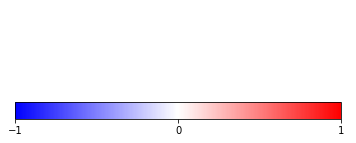

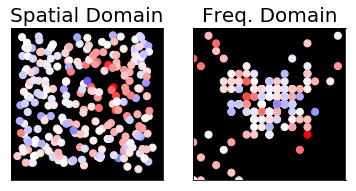

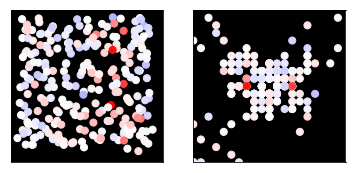

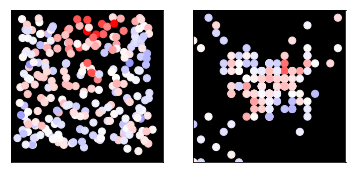

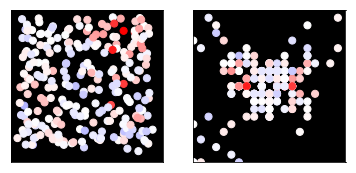

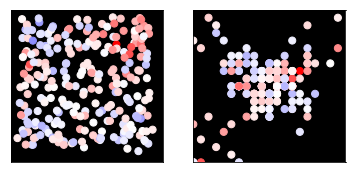

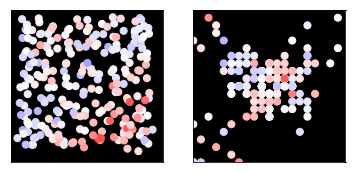

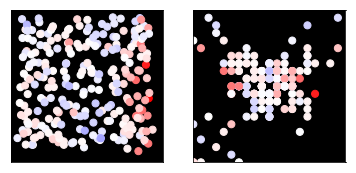

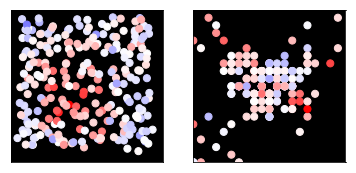

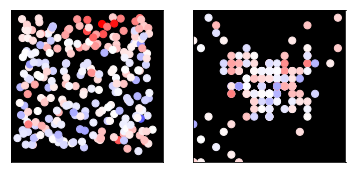

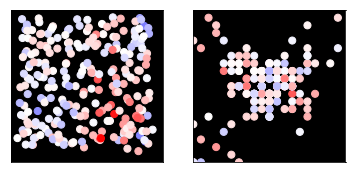

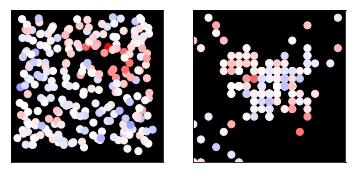

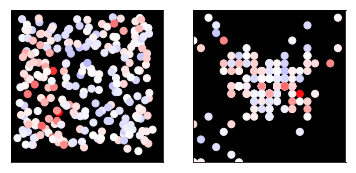

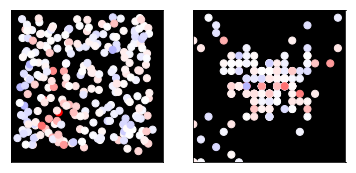

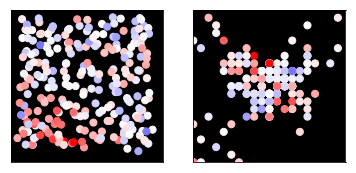

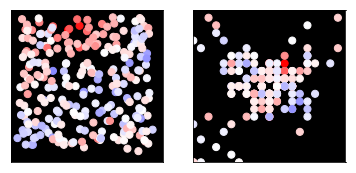

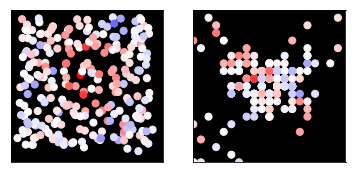

In [21]:
num_pooling_filters = 16

filter_idx_list = np.arange(num_pooling_filters, dtype=np.int32)
cmap = plt.get_cmap("bwr")
cNorm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
num_bfs = bf_stats["num_outputs"]

# Get raw points
x_p_cent = [x for (y,x) in bf_stats["gauss_centers"]]
y_p_cent = [y for (y,x) in bf_stats["gauss_centers"]]
x_f_cent = [x for (y,x) in bf_stats["fourier_centers"]]
y_f_cent = [y for (y,x) in bf_stats["fourier_centers"]]
max_sf = np.max(np.abs(x_f_cent+y_f_cent))

fig, sub_ax = plt.subplots(1, figsize=(6,2))
scalarMap._A = []
cbar = fig.colorbar(scalarMap, ax=sub_ax, ticks=[-1, 0, 1], orientation="horizontal")
sub_ax.set_yticklabels([])
sub_ax.set_xticklabels([])
sub_ax.spines["right"].set_color("none")
sub_ax.spines["top"].set_color("none")
sub_ax.spines["left"].set_color("none")
sub_ax.spines["bottom"].set_color("none")
sub_ax.tick_params(axis="both", bottom="off", top="off", left="off", right="off")
for filter_id in range(num_pooling_filters):
  fig, sub_ax = plt.subplots(1, 2, figsize=(6,6))
  example_filter = pooling_filters[:, filter_id]
  filter_norm = np.max(np.abs(example_filter))
  connection_colors = [scalarMap.to_rgba(example_filter[bf_idx]/filter_norm)
    for bf_idx in range(num_bfs)]
  sub_ax[0].scatter(x_p_cent, y_p_cent, c=connection_colors, s=50)
  sub_ax[0].set_xlim(0, bf_stats["patch_edge_size"]-1)
  sub_ax[0].set_ylim(0, bf_stats["patch_edge_size"]-1)
  sub_ax[0].invert_yaxis()
  sub_ax[0].set_yticklabels([])
  sub_ax[0].set_xticklabels([])
  sub_ax[0].tick_params(axis="both", bottom="off", top="off", left="off", right="off")
  sub_ax[0].set_aspect("equal")
  sub_ax[0].set_facecolor("k")
  sub_ax[1].scatter(x_f_cent, y_f_cent, c=connection_colors, s=50)
  sub_ax[1].set_xlim([-max_sf, max_sf])
  sub_ax[1].set_ylim([-max_sf, max_sf])
  sub_ax[1].set_yticklabels([])
  sub_ax[1].set_xticklabels([])
  sub_ax[1].tick_params(axis="both", bottom="off", top="off", left="off", right="off")
  sub_ax[1].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
  sub_ax[1].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
  sub_ax[1].set_aspect("equal")
  sub_ax[1].set_facecolor("k")
  if filter_id == 0:
    sub_ax[0].set_title("Spatial Domain", fontsize=20)
    sub_ax[1].set_title("Freq. Domain", fontsize=20)
  
plt.show()

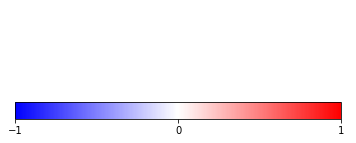

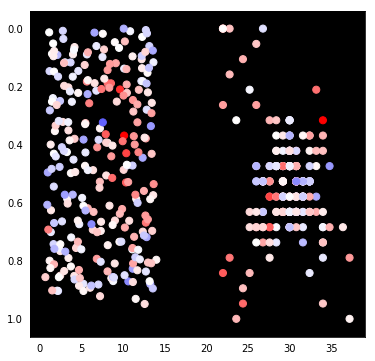

In [22]:
num_pooling_filters = 16
plot_offset = 16

filter_idx_list = np.arange(num_pooling_filters, dtype=np.int32)
cmap = plt.get_cmap("bwr")
cNorm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
num_bfs = bf_stats["num_outputs"]

# Get raw points
x_p_cent = [x for (y,x) in bf_stats["gauss_centers"]]
y_p_cent = [y for (y,x) in bf_stats["gauss_centers"]]
y_p_norm = [(y-np.min(y_p_cent))/np.max(np.abs(y_p_cent)) for y in y_p_cent]

x_f_cent = [x for (y,x) in bf_stats["fourier_centers"]]
x_f_shift = [x+np.max(x_p_cent)+plot_offset for x in x_f_cent]
y_f_cent = [y for (y,x) in bf_stats["fourier_centers"]]
y_f_norm = [(y-np.min(y_f_cent))/np.max(y_f_cent-np.min(y_f_cent)) for y in y_f_cent]

fig, sub_ax = plt.subplots(1, figsize=(6,2))
scalarMap._A = []
cbar = fig.colorbar(scalarMap, ax=sub_ax, ticks=[-1, 0, 1], orientation="horizontal")
sub_ax.set_yticklabels([])
sub_ax.set_xticklabels([])
sub_ax.spines["right"].set_color("none")
sub_ax.spines["top"].set_color("none")
sub_ax.spines["left"].set_color("none")
sub_ax.spines["bottom"].set_color("none")
sub_ax.tick_params(axis="both", bottom="off", top="off", left="off", right="off")

filter_id = 0

fig, sub_ax = plt.subplots(1, figsize=(6,6))
example_filter = pooling_filters[:, filter_id]
filter_norm = np.max(np.abs(example_filter))

connection_colors = [scalarMap.to_rgba(example_filter[bf_idx]/filter_norm)
  for bf_idx in range(num_bfs)]*2

x_vals = x_p_cent + x_f_shift
y_vals = y_p_norm + y_f_norm

sub_ax.scatter(x_vals, y_vals, c=connection_colors, s=50)
#sub_ax.set_xlim(0, bf_stats["patch_edge_size"]-1)
#sub_ax.set_ylim(0, bf_stats["patch_edge_size"]-1)
sub_ax.invert_yaxis()
#sub_ax.set_yticklabels([])
#sub_ax.set_xticklabels([])
sub_ax.tick_params(axis="both", bottom="off", top="off", left="off", right="off")
#sub_ax.set_aspect("equal")
sub_ax.set_facecolor("k")
#if filter_id == 0:
#  sub_ax[0].set_title("Spatial Domain", fontsize=20)
#  sub_ax[1].set_title("Freq. Domain", fontsize=20)
  
plt.show()

tot=25
num_y=5
num_x=5


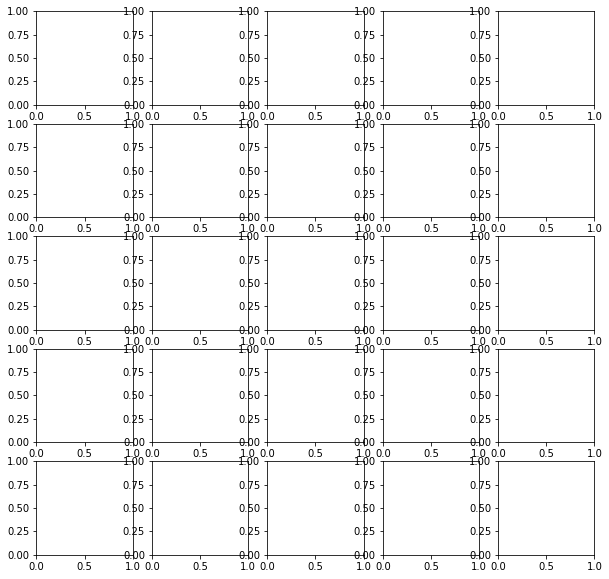

In [57]:
num_pooling_filters = 4

filter_idx_list = np.arange(num_pooling_filters, dtype=np.int32)
cmap = plt.get_cmap("bwr")
cNorm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
num_bfs = bf_stats["num_outputs"]

# Get raw points
x_p_cent = [x for (y,x) in bf_stats["gauss_centers"]]
y_p_cent = [y for (y,x) in bf_stats["gauss_centers"]]
x_f_cent = [x for (y,x) in bf_stats["fourier_centers"]]
y_f_cent = [y for (y,x) in bf_stats["fourier_centers"]]
max_sf = np.max(np.abs(x_f_cent+y_f_cent))

num_filters_y = int(np.ceil(np.sqrt(num_pooling_filters)))
num_plots_y = num_filters_y*2+num_filters_y-1

num_filters_x = int(np.floor(np.sqrt(num_pooling_filters)))
num_plots_x = num_filters_x*2 + num_filters_x-1
num_plots = (num_plots_x, num_plots_y)

print("tot="+str(num_plots[0]*num_plots[1]))
print("num_y="+str(num_plots_y))
print("num_x="+str(num_plots_x))

#fig, sub_ax = plt.subplots(num_plots_y, num_plots_x, figsize=(10,10))
fig = plt.figure(figsize=(10,10))
#gs = gsp.GridSpec(num_plots_y, num_plots_x)

#ax = plt.subplot2grid((num_plots_y, num_plots_x), (0, 0), colspan=1, rowspan=2)
#scalarMap._A = []
#cbar = fig.colorbar(scalarMap, ax=ax, ticks=[-1, 0, 1], orientation="horizontal")
#sub_ax.set_yticklabels([])
#sub_ax.set_xticklabels([])
#sub_ax.spines["right"].set_color("none")
#sub_ax.spines["top"].set_color("none")
#sub_ax.spines["left"].set_color("none")
#sub_ax.spines["bottom"].set_color("none")
#sub_ax.tick_params(axis="both", bottom="off", top="off", left="off", right="off")

filter_id = 0
for plot_id in  np.ndindex(num_plots):
  if y_id%2 == 0:
    ax = plt.subplot2grid(num_plots, plot_id, colspan=1, rowspan=2)
  else:
    ax = plt.subplot2grid(num_plots, plot_id, colspan=1, rowspan=1)
  #if filter_id < num_pooling_filters:
  #  (y_id, x_id) = plot_id
  #  example_filter = pooling_filters[:, filter_id]
  #  filter_norm = np.max(np.abs(example_filter))
  #  connection_colors = [scalarMap.to_rgba(example_filter[bf_idx]/filter_norm)
  #    for bf_idx in range(num_bfs)]
  #  if y_id == 0:
  #    pass
  #  if x_id%3 == 0: #every third row is a spacer
  #    ax = plt.subplot2grid((num_plots_y, num_plots_x), plot_id, colspan=1, rowspan=2)
  #    #ax.spines["right"].set_color("none")
  #    #ax.spines["top"].set_color("none")
  #    #ax.spines["left"].set_color("none")
  #    #ax.spines["bottom"].set_color("none")
  #    #ax.tick_params(axis="both", bottom="off", top="off", left="off", right="off")
  #    #ax.get_xaxis().set_visible(False)
  #    #ax.get_yaxis().set_visible(False)
  #    pass
  #  if y_id%3 == 0: #every third column is a spacer
  #    ax = plt.subplot2grid((num_plots_y, num_plots_x), plot_id, colspan=2, rowspan=1)
  #    #ax.spines["right"].set_color("none")
  #    #ax.spines["top"].set_color("none")
  #    #ax.spines["left"].set_color("none")
  #    #ax.spines["bottom"].set_color("none")
  #    #ax.tick_params(axis="both", bottom="off", top="off", left="off", right="off")
  #    #ax.get_xaxis().set_visible(False)
  #    #ax.get_yaxis().set_visible(False)
  #    pass
  #  if x_id%2 == 0:
  #    ax = plt.subplot2grid((num_plots_y, num_plots_x), plot_id, colspan=1, rowspan=1)
  #    #ax.scatter(x_p_cent, y_p_cent, c=connection_colors, s=50)
  #    #ax.set_xlim(0, bf_stats["patch_edge_size"]-1)
  #    #ax.set_ylim(0, bf_stats["patch_edge_size"]-1)
  #    #ax.invert_yaxis()
  #    #ax.set_yticklabels([])
  #    #ax.set_xticklabels([])
  #    #ax.tick_params(axis="both", bottom="off", top="off", left="off", right="off")
  #    #ax.set_aspect("equal")
  #    #ax.set_facecolor("k")
  #  else:
  #    ax = plt.subplot2grid((num_plots_y, num_plots_x), plot_id, colspan=1, rowspan=1)
  #    #ax.scatter(x_f_cent, y_f_cent, c=connection_colors, s=50)
  #    #ax.set_xlim([-max_sf, max_sf])
  #    #ax.set_ylim([-max_sf, max_sf])
  #    #ax.set_yticklabels([])
  #    #ax.set_xticklabels([])
  #    #ax.tick_params(axis="both", bottom="off", top="off", left="off", right="off")
  #    #ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
  #    #ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
  #    #ax.set_aspect("equal")
  #    #ax.set_facecolor("k")
  #    filter_id += 1
  #else:
  #  ax = plt.subplot2grid((num_plots_y, num_plots_x), plot_id, colspan=1, rowspan=1)
  #  ax.spines["right"].set_color("none")
  #  ax.spines["top"].set_color("none")
  #  ax.spines["left"].set_color("none")
  #  #ax.spines["bottom"].set_color("none")
  #  ax.tick_params(axis="both", bottom="off", top="off", left="off", right="off")
  #  #ax.get_xaxis().set_visible(False)
  #  ax.get_yaxis().set_visible(False)
  #  ax.set_aspect("equal") 

#for filter_id in range(num_pooling_filters):
#  fig, sub_ax = plt.subplots(1, 2, figsize=(6,6))
#  example_filter = pooling_filters[:, filter_id]
#  filter_norm = np.max(np.abs(example_filter))
#  connection_colors = [scalarMap.to_rgba(example_filter[bf_idx]/filter_norm)
#    for bf_idx in range(num_bfs)]
#  sub_ax[0].scatter(x_p_cent, y_p_cent, c=connection_colors, s=50)
#  sub_ax[0].set_xlim(0, bf_stats["patch_edge_size"]-1)
#  sub_ax[0].set_ylim(0, bf_stats["patch_edge_size"]-1)
#  sub_ax[0].invert_yaxis()
#  sub_ax[0].set_yticklabels([])
#  sub_ax[0].set_xticklabels([])
#  sub_ax[0].tick_params(axis="both", bottom="off", top="off", left="off", right="off")
#  sub_ax[0].set_aspect("equal")
#  sub_ax[0].set_facecolor("k")
#  sub_ax[1].scatter(x_f_cent, y_f_cent, c=connection_colors, s=50)
#  sub_ax[1].set_xlim([-max_sf, max_sf])
#  sub_ax[1].set_ylim([-max_sf, max_sf])
#  sub_ax[1].set_yticklabels([])
#  sub_ax[1].set_xticklabels([])
#  sub_ax[1].tick_params(axis="both", bottom="off", top="off", left="off", right="off")
#  sub_ax[1].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
#  sub_ax[1].yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
#  sub_ax[1].set_aspect("equal")
#  sub_ax[1].set_facecolor("k")
#  if filter_id == 0:
#    sub_ax[0].set_title("Spatial Domain", fontsize=20)
#    sub_ax[1].set_title("Freq. Domain", fontsize=20)
  
plt.show()